# Language inference with BERT

This notebook contains code based on BERT ROBERTA and Pytorch for entering a submission to the Kaggle competion [Contradictory, My Dear Watson](https://www.kaggle.com/c/contradictory-my-dear-watson). It also demonstrated how to setup Pytorch on TPUs.

It is based on parts of the following notebooks:

* [Tutorial notbook](https://www.kaggle.com/anasofiauzsoy/tutorial-notebook)
for the competion by Ana Sofia Uzsoy.
* [BERT Fine-Tuning Tutorial with PyTorch](https://mccormickml.com/2019/07/22/BERT-fine-tuning) by McCormick and Nick Ryan


# Mount Google Drive and download the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

! cp /content/drive/MyDrive/Kaggle/contradictory-my-dear-watson.zip .
! unzip -o contradictory-my-dear-watson.zip
! ls -alh

Mounted at /content/drive
Archive:  contradictory-my-dear-watson.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               
total 5.7M
drwxr-xr-x 1 root root 4.0K May 16 19:16 .
drwxr-xr-x 1 root root 4.0K May 16 18:50 ..
drwxr-xr-x 4 root root 4.0K May  6 13:43 .config
-rw------- 1 root root 1.8M May 16 19:16 contradictory-my-dear-watson.zip
drwx------ 5 root root 4.0K May 16 19:16 drive
drwxr-xr-x 1 root root 4.0K May  6 13:44 sample_data
-rw-r--r-- 1 root root  66K Jul 27  2020 sample_submission.csv
-rw-r--r-- 1 root root 1.2M Jul 27  2020 test.csv
-rw-r--r-- 1 root root 2.7M Jul 27  2020 train.csv


In [ ]:
import os
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F

print('Pytorch version: ', torch.__version__)


Pytorch version:  1.8.1+cu101


In [ ]:
try:
  if os.environ['COLAB_TPU_ADDR']:
    device = xm.xla_device(n=1, devkind='TPU') # TODO how many?
    print('Using TPU device: ', device)
except KeyError:
  if torch.cuda.is_available():
    device = 'cuda'
    print('Using GPU device: ', device)
  else:
    device = 'cpu'
    print('Neither TPU nor CUDA found, using CPU: ', device)



Using GPU device:  cuda


In [ ]:
try:
  if os.environ['COLAB_TPU_ADDR']: # TODO catch exception if running without TPU
    !pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.8.1-cp37-cp37m-linux_x86_64.whl

    import torch_xla
    import torch_xla.core.xla_model as xm

    print('Installed pytorch XLA version: ', torch_xla.__version__)

except KeyError:
  print('No TPU detected, skipping installation of Pytorch/XLS')

No TPU detected, skipping installation of Pytorch/XLS


In [ ]:
!pip -q install transformers[torch]

import transformers

print('Installed transformers version: ', transformers.__version__)

     |████████████████████████████████| 2.3MB 4.1MB/s 
     |████████████████████████████████| 901kB 41.6MB/s 
     |████████████████████████████████| 3.3MB 41.1MB/s 
Installed transformers version:  4.6.0


In [ ]:
# Fix the seed to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Load the data into pandas and check the distribution of the samples

In [ ]:
train = pd.read_csv('train.csv')
train.head()

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1


In [ ]:
test = pd.read_csv('test.csv')
test.head()

,id,premise,hypothesis,lang_abv,language
0,c6d58c3f69,بکس، کیسی، راہیل، یسعیاہ، کیلی، کیلی، اور کولم...,"کیسی کے لئے کوئی یادگار نہیں ہوگا, کولمین ہائی...",ur,Urdu
1,cefcc82292,هذا هو ما تم نصحنا به.,عندما يتم إخبارهم بما يجب عليهم فعله ، فشلت ال...,ar,Arabic
2,e98005252c,et cela est en grande partie dû au fait que le...,Les mères se droguent.,fr,French
3,58518c10ba,与城市及其他公民及社区组织代表就IMA的艺术发展进行对话&amp,IMA与其他组织合作，因为它们都依靠共享资金。,zh,Chinese
4,c32b0d16df,Она все еще была там.,"Мы думали, что она ушла, однако, она осталась.",ru,Russian


In [ ]:
sample = pd.read_csv('sample_submission.csv')
sample.head()

,id,prediction
0,c6d58c3f69,1
1,cefcc82292,1
2,e98005252c,1
3,58518c10ba,1
4,c32b0d16df,1


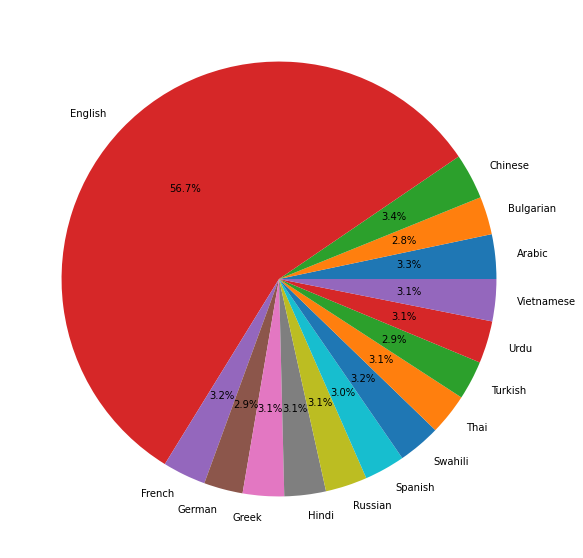

In [ ]:
labels, frequencies = np.unique(train.language.values, return_counts=True)

plt.figure(figsize = (10, 10))
plt.pie(frequencies, labels=labels, autopct='%1.1f%%')
plt.show()

# Encode the data

First get the maximum length of the concatenated sentences.
Then create the Bert input IDs, attention masks, and token type ids. 
Lastly, create the Torch datasets with training and validation splits.

In [ ]:
# The name of the model we'll be using
#model_name = 'bert-base-multilingual-cased'
#model_name = 'xlm-roberta-base'
model_name = 'xlm-roberta-large'

# Create the tokenizer
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)


Max encoded sentences length: 246


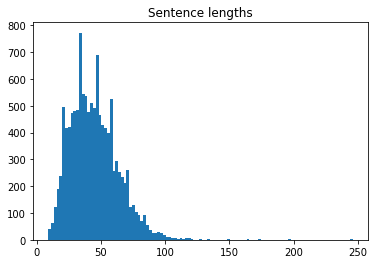

,length
count,12120.000000
mean,44.991667
std,19.403881
min,9.000000
50%,43.000000
75%,56.000000
90%,69.000000
95%,78.000000
99%,98.000000
max,246.000000


In [ ]:
# Determine the max length of encoded sentences

lengths = []
for prem, hyp in zip(train['premise'].values, train['hypothesis'].values):
  input_ids = tokenizer.encode(text=prem, text_pair=hyp)
  l = len(input_ids)
  lengths.append(l)
 
  
print("Max encoded sentences length: {}".format(np.max(lengths)))

plt.hist(x=lengths, bins='auto')
plt.title('Sentence lengths')
plt.show()

df = pd.DataFrame(lengths, columns=['length'])
df.describe(percentiles=[.75,.9,.95,.99])

In [ ]:
def encode(premises, hypotheses):
  input_ids = []
  attention_masks = []
  token_type_ids = []

  for prem, hyp in zip(premises, hypotheses):
    encoded_dict = tokenizer.encode_plus(text=prem, 
                                        text_pair=hyp,
                                        add_special_tokens=True,
                                        max_length=98,
                                        padding='max_length',
                                        truncation=True,
                                        return_attention_mask = True,
                                        return_token_type_ids = True,
                                        return_tensors = 'pt')
    
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])
    token_type_ids.append(encoded_dict['token_type_ids'])

  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)
  token_type_ids = torch.cat(token_type_ids, dim=0)

  return input_ids, attention_masks, token_type_ids

train_input_ids, train_attention_masks, train_token_type_ids = encode(train['premise'].values, train['hypothesis'].values)

In [ ]:
train_labels = torch.tensor(train['label'].values)

In [ ]:
from torch.utils.data import TensorDataset, random_split

dataset = TensorDataset(train_input_ids, train_attention_masks, train_token_type_ids, train_labels)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))


9,696 training samples
2,424 validation samples


In [ ]:
from torch.utils.data import DataLoader

# For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32.
batch_size = 32

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size = batch_size)
val_dataloader = DataLoader(val_dataset, batch_size = batch_size)

# Training and validation

In [ ]:
from transformers import AutoModelForSequenceClassification, AdamW, BertConfig

model = AutoModelForSequenceClassification.from_pretrained(model_name,
                                                           num_labels=3,  
                                                           output_attentions = False,
                                                           output_hidden_states = False)
#print(model)
model.to(device)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'lm_head.decoder.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense

XLMRobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (La

XLMRobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (La

In [ ]:
from transformers import get_linear_schedule_with_warmup

# Learning rate (Adam): 5e-5, 3e-5, 2e-5
lr = 5e-5

optimizer = AdamW(model.parameters(), lr = lr, eps=1e-8)
                  
# Number of epochs: 2, 3, 4
epochs = 4

# Create a learning rate scheduler
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=total_steps)

In [ ]:
import time, datetime

def format_time(elapsed):
  return str(datetime.timedelta(seconds=round(elapsed)))

In [ ]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
def training_loop(num_epochs):
  """
  """

  training_stats = []

  for epoch in range (num_epochs):
    
    print("")
    print("Epoch {:} / {:}".format(epoch + 1, num_epochs))
    print("Training....")
    
    total_train_loss = 0
    t0 = start_t0 = time.time()

    model.train()

    for step, batch in enumerate(train_dataloader):
      if step % 40 == 0 and step != 0:
        print("Batch: {:} / {:}, Elapsed: {:}".format(step, len(train_dataloader), format_time(time.time() - t0)))
     
      b_input_ids = batch[0].to(device)
      b_attention_masks = batch[1].to(device) 
      b_token_type_ids = batch[2].to(device) 
      b_labels = batch[3].to(device)

      model.zero_grad()
      output = model.forward(b_input_ids, 
                             attention_mask=b_attention_masks, 
                             token_type_ids=b_token_type_ids,
                             labels=b_labels)
      
      loss = output['loss']
      logits = output['logits']
   
      total_train_loss += loss.item()
      
      loss.backward()

      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
      optimizer.step()
      scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)            
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))

    print("Validating....")
    print("")
    
    total_eval_accuracy = 0
    total_eval_loss = 0
    t0 = time.time()

    eval_steps = 0
    model.eval()

    for batch in val_dataloader:
    
      b_input_ids = batch[0].to(device)
      b_attention_masks = batch[1].to(device) 
      b_token_type_ids = batch[2].to(device) 
      b_labels = batch[3].to(device)

      model.zero_grad()
      with torch.no_grad():
        output = model.forward(b_input_ids, 
                               attention_mask=b_attention_masks, 
                               token_type_ids=b_token_type_ids,
                               labels=b_labels)
      
        loss = output['loss']
        logits = output['logits']

        total_eval_loss += loss.item()
      
        if device != 'cpu':
          logits = logits.detach().cpu().numpy()
          label_ids = b_labels.to('cpu').numpy()

        total_eval_accuracy += flat_accuracy(logits, label_ids)
        
        eval_steps += 1
    
    avg_val_accuracy = total_eval_accuracy / eval_steps
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    avg_val_loss = total_eval_loss / eval_steps
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    training_stats.append(
        {
            'epoch': epoch + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

  print("")
  print("Training complete!")

  print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-start_t0)))
  
  return training_stats                      
        


In [ ]:
training_stats = training_loop(num_epochs=epochs)


Epoch 1 / 5
Training....
Batch: 40 / 606, Elapsed: 0:00:25
Batch: 80 / 606, Elapsed: 0:00:51
Batch: 120 / 606, Elapsed: 0:01:16
Batch: 160 / 606, Elapsed: 0:01:42
Batch: 200 / 606, Elapsed: 0:02:07
Batch: 240 / 606, Elapsed: 0:02:33
Batch: 280 / 606, Elapsed: 0:02:58
Batch: 320 / 606, Elapsed: 0:03:24
Batch: 360 / 606, Elapsed: 0:03:49
Batch: 400 / 606, Elapsed: 0:04:15
Batch: 440 / 606, Elapsed: 0:04:40
Batch: 480 / 606, Elapsed: 0:05:06
Batch: 520 / 606, Elapsed: 0:05:31
Batch: 560 / 606, Elapsed: 0:05:57
Batch: 600 / 606, Elapsed: 0:06:22

  Average training loss: 1.04
  Training epoch took: 0:06:26
Validating....

  Accuracy: 0.63
  Validation Loss: 0.86
  Validation took: 0:00:29

Epoch 2 / 5
Training....
Batch: 40 / 606, Elapsed: 0:00:25
Batch: 80 / 606, Elapsed: 0:00:51
Batch: 120 / 606, Elapsed: 0:01:17
Batch: 160 / 606, Elapsed: 0:01:42
Batch: 200 / 606, Elapsed: 0:02:08
Batch: 240 / 606, Elapsed: 0:02:33
Batch: 280 / 606, Elapsed: 0:02:59
Batch: 320 / 606, Elapsed: 0:03:24
B

# Evaluation

In [ ]:
pd.set_option('precision', 2)

training_stats_df = pd.DataFrame(data=training_stats)
training_stats_df = training_stats_df.set_index('epoch')

training_stats_df

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,1.04,0.86,0.63,0:06:26,0:00:29
2,0.81,0.71,0.71,0:06:26,0:00:29
3,0.60,0.68,0.72,0:06:26,0:00:29
4,0.47,0.76,0.73,0:06:26,0:00:29
5,0.36,0.81,0.74,0:06:26,0:00:29


# Prepare the submission

In [ ]:
test_input_ids, test_attention_masks, test_token_type_ids = encode(test['premise'].values, test['hypothesis'].values)
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_token_type_ids)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size)

model.eval()
preds = []

for batch in test_dataloader:
  test_input_ids = batch[0].to(device)
  test_attention_masks = batch[1].to(device)
  test_token_type_ids = batch[2].to(device)

  with torch.no_grad():
    out = model.forward(test_input_ids, attention_mask=test_attention_masks, token_type_ids=test_token_type_ids)
  
  logits = out['logits'].detach().cpu().numpy()
  preds.extend(np.argmax(logits, axis=1).flatten())

output = pd.DataFrame({'id': test['id'], 'prediction': preds})
output.to_csv('submission.csv',index=False)
output.head()

,id,prediction
0,c6d58c3f69,2
1,cefcc82292,1
2,e98005252c,0
3,58518c10ba,1
4,c32b0d16df,0


In [ ]:
!cp submission.csv /content/drive/MyDrive/Kaggle/contradictory-my-dear-watson.submission.001.csv